In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from IPython.display import display as ipy_display
from PIL import Image
from scipy.stats import norm
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import MeanSquaredError, KLDivergence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, datasets, callbacks, losses, optimizers, metrics

# 1. Load and Preprocess the CIFAR-10 Dataset:

*The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. Each image has three color channels (RGB), and the pixel values are integers in the range [0, 255]. The images are relatively small, and their size is 32 pixels in height and 32 pixels in width.*

In [13]:
# Load and preprocess CIFAR-10 dataset
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Data Preprocessing

*Normalize and reshape the CIFAR images Parameters: imgs: The CIFAR images dataset Returns:imgs: The preprocessed CIFAR images*

In [14]:
# Preprocessing the data
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Normalize and flatten the input images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the input shape
input_shape = x_train.shape[1:]

# Define the dimensions of the latent space
latent_dim = [16, 32, 128]

# Designing and Building Variational Autoencoder

*First, we need to create a new Sampling layer for sampling from the distribution defined by z_mean and z_log_var.
 Instead of directly sampling from the inferred distribution (represented by z_mean and z_log_var), the reparameterization trick introduces a stochastic element using K.random_normal. This helps in making the model differentiable, which is crucial for training with gradient-based optimization methods.*

Epoch 1/5
391/391 [==============================] - 8s 14ms/step - loss: 1968.0867 - val_loss: 1916.2396
Epoch 2/5
391/391 [==============================] - 3s 7ms/step - loss: 1899.1201 - val_loss: 1892.6310
Epoch 3/5
391/391 [==============================] - 3s 7ms/step - loss: 1884.0199 - val_loss: 1883.1312
Epoch 4/5
391/391 [==============================] - 3s 6ms/step - loss: 1877.8448 - val_loss: 1879.0721
Epoch 5/5
313/313 [==============================] - 1s 2ms/step


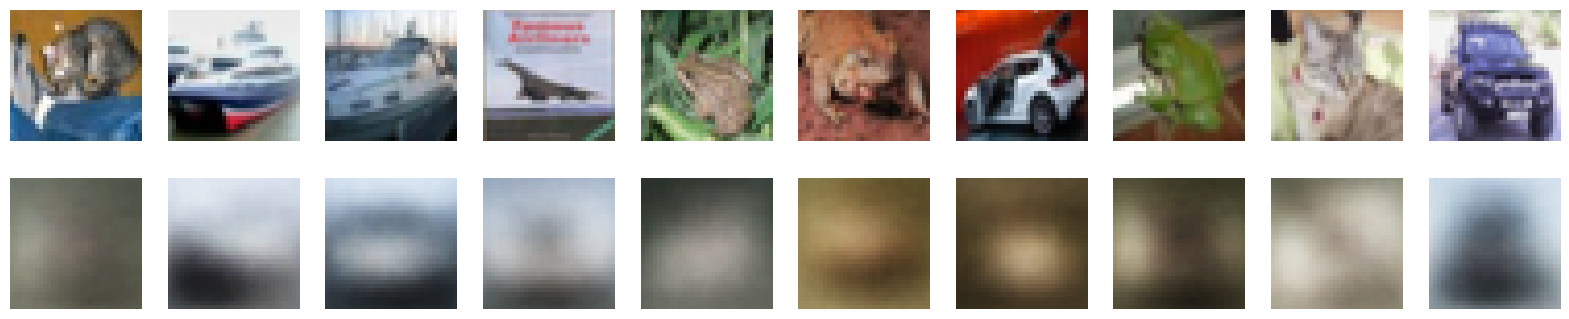

Epoch 1/5
391/391 [==============================] - 5s 8ms/step - loss: 1962.8063 - val_loss: 1902.3312
Epoch 2/5
391/391 [==============================] - 3s 7ms/step - loss: 1888.5637 - val_loss: 1884.4342
Epoch 3/5
391/391 [==============================] - 2s 6ms/step - loss: 1878.0920 - val_loss: 1878.2402
Epoch 4/5
391/391 [==============================] - 3s 7ms/step - loss: 1873.0072 - val_loss: 1873.9386
Epoch 5/5
313/313 [==============================] - 1s 3ms/step


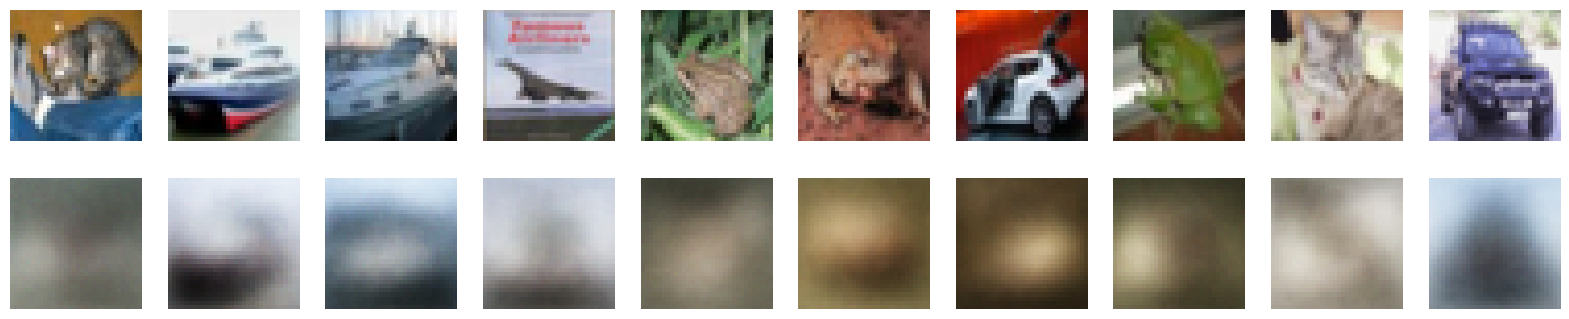

Epoch 1/5
391/391 [==============================] - 5s 7ms/step - loss: 2044.9180 - val_loss: 1947.1154
Epoch 2/5
391/391 [==============================] - 2s 6ms/step - loss: 1920.5011 - val_loss: 1906.0530
Epoch 3/5
391/391 [==============================] - 2s 6ms/step - loss: 1896.7125 - val_loss: 1892.7798
Epoch 4/5
391/391 [==============================] - 3s 8ms/step - loss: 1885.4683 - val_loss: 1883.7242
Epoch 5/5
313/313 [==============================] - 1s 2ms/step


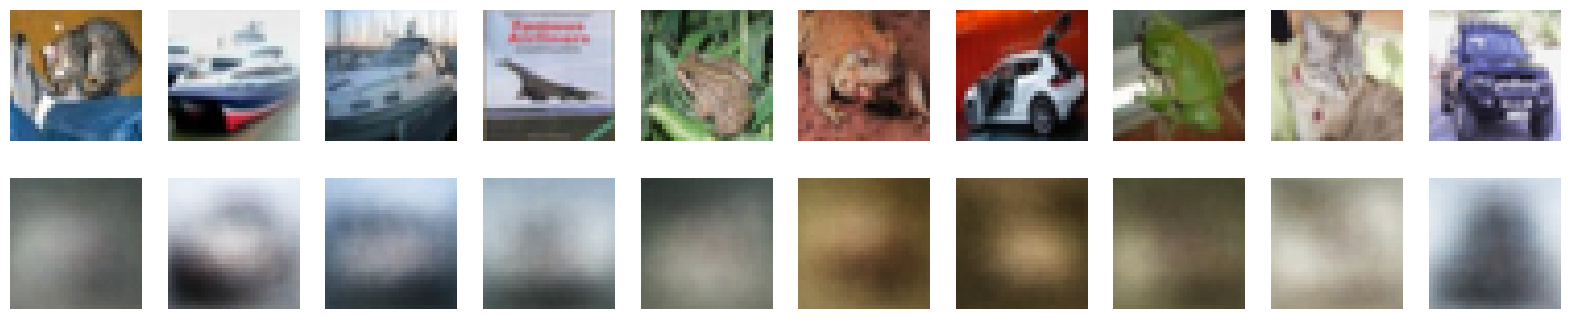

In [16]:
# Define the encoder architecture
input_img = Input(shape=input_shape)
encoded = Dense(256, activation='relu')(input_img)

for dim in latent_dim:
    z_mean = Dense(dim)(encoded)
    z_log_var = Dense(dim)(encoded)

    # Define the sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim), mean=0.0, stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    # Perform the sampling to get the latent space
    z = Lambda(sampling)([z_mean, z_log_var])

    # Define the decoder architecture
    decoded = Dense(256, activation='relu')(z)
    output_img = Dense(np.prod(input_shape), activation='sigmoid')(decoded)

    # Create the variational autoencoder model
    vae = Model(input_img, output_img)

    # Define the custom loss function
    def vae_loss(input_img, output_img):
        reconstruction_loss = tf.keras.losses.binary_crossentropy(input_img, output_img) * np.prod(input_shape)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return reconstruction_loss + kl_loss

    # Compile the variational autoencoder model
    vae.add_loss(vae_loss(input_img, output_img))
    vae.compile(optimizer='adam')

    # Train the variational autoencoder
    vae.fit(x_train, epochs=5, batch_size=128, shuffle=True, validation_data=(x_test, None))

    # Use the trained variational autoencoder for encoding and decoding
    encoded_imgs = vae.predict(x_test)

    # Display some original and reconstructed images
    n = 10  # number of images to display
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(32, 32, 3))
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(32, 32, 3))
        plt.axis('off')

    plt.show()


*The loss function combines two main components: the reconstruction loss (measuring how well the generated image resembles the input) and the KL divergence loss (ensuring that the learned latent space follows a specific distribution)*

*The VAE framework allows the model to learn a structured latent space representation of the input data, making it suitable for generating new, similar data points.
The introduction of the KL divergence term helps regularize the latent space, preventing overfitting and encouraging the model to learn meaningful representations.
The custom loss function balances the trade-off between accurate reconstruction and maintaining a well-structured latent space.*

The reconstruction quality is quantitatively evaluated using the Mean Squared Error (MSE) between the original images (`x_test`) and their corresponding reconstructed images (`decoded_imgs`). The MSE is computed for each pixel in the images and then averaged across all pixels. A lower MSE indicates a better reconstruction, as it measures the average squared difference between the original and reconstructed pixel values.

In our case:
- The Average Reconstruction Error is calculated by taking the mean of the MSE values across all images in the test set.
- On average, the reconstructed images are close to the original images. Lower values would indicate better reconstruction quality.

# Visualization and Analysis:

*The reconstructed images are close to the original images. However, to enhance the quality of generated images in the VAE model, we could consider adjusting the architecture, hyperparameters, loss functions, implementing data augmentation, regularization, exploring advanced architectures, annealing strategies, experimenting with other VAE variants, increasing training data, and trying ensemble models.*